# Extracting R90 from Sérsic profiles
### The aim is to use GALFIT-derived model parameters (namely R50 and nser) in order to find R90 for our subsample galaxies.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.special import gamma, gammainc, gammaincinv
import os
homedir = os.getenv("HOME")

The 2D surface brightness distribution of a Sersic profile is 
#### $I(r) = I_e \exp{[-b_n((\frac{r}{r_e})^{1/n}-1)]}$,
where \
$I_e = I(r_e)$ \
$b_n$ = gammaincinv(2n, 0.5) (defined such that $r_e$ contains 1/2 the total flux of the profile) \

Integrated, the function L(<r) for *enclosed flux* is
#### $L(<r) = \frac{2\pi n r_e^2}{b_n^{2n}}I_e e^{b_n}\gamma(2n, b_n (\frac{r}{r_e})^{1/n}$)

In [141]:
def L(r,re,n):
    I_e = 1     #just a brightness normalization term; set equal to 1.
    b_n = gammaincinv(2*n, 0.5)
    r_ratio = r/re
    constant = 2*np.pi*n*(re**2)/b_n**(2*n)
    gamma_term = gammainc(2*n,b_n*(r_ratio**(1/n)))               #note that scipy.special.gammainc is NORMALIZED. 
                                                                  #need to multiple gamma_term * gamma(2*n) in cases
                                                                  #where I'm not calculating an L ratio or I care
                                                                  #about units, etc.
    
    return constant*I_e*np.exp(b_n)*gamma_term

In [48]:
def find_rval(L_output,r,frac=0.90):
    dist = np.abs((L_output/np.max(L_output)) - frac)
    rval_index = np.where(dist==np.min(dist))[0][0]
    return np.round(r[rval_index],4)

In [167]:
#we can begin with defining a few arbitrary n and re values. r is simply a range of arbitrary values (some
#multiple of re) that is needed to generate the profiles
n = 4
re = 10*2.75
r = np.arange(1,300*re,.1)

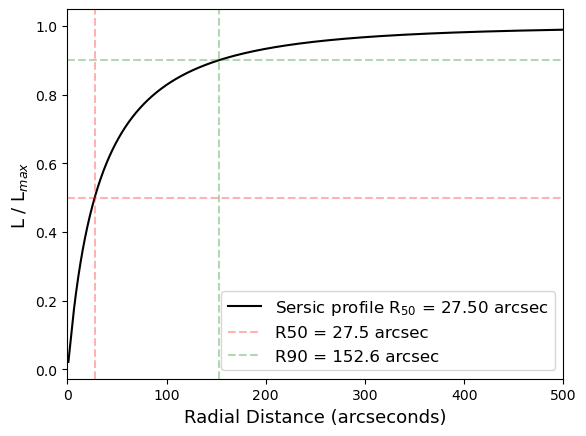

In [171]:
plt.plot(r,L(r,re,n)/np.max(L(r,re,n)),label=r'Sersic profile R$_{50}$ = %.2f arcsec'%re,color='black')
plt.axvline(find_rval(L(r,re,n),r,0.50),color='r',ls='--',alpha=0.3)
plt.axhline(0.5,color='r',ls='--',alpha=0.3,label=f'R50 = {find_rval(L(r,re,n),r,0.50)} arcsec')

plt.axvline(find_rval(L(r,re,n),r,0.90),ls='--',color='g',alpha=0.3)
plt.axhline(0.9,color='g',alpha=0.3,ls='--',label=f'R90 = {find_rval(L(r,re,n),r,0.90)} arcsec')

plt.xlabel('Radial Distance (arcseconds)',fontsize=13)
plt.ylabel(r'L / L$_{max}$',fontsize=13)

plt.legend(fontsize=12)
plt.xlim(0,500)

plt.show()

For the above figure, as n grows with a fixed R50 so too does the discrepancy between the given R50 variable and the extracted R50. The reason is because a larger n results in a Sersic profile more extended on the outskirts, so we need a larger multiple of re for our r array in order to encompass as much of the galaxy's light as possible. Rather than needing to vary the size of the rmax for EVERY galaxy, I can just create a function for r90.

Solving L(<r) for r, I *think*,

### $r = r_e \Big[\frac{1}{b_n}$gammainvinc($2n, \frac{Lb_n^{2n}}{2\pi n r_e^2I_e e^{b_n}}$) $\Big]^n$

##### Also note that units are not a concern presently. :-)
###### (though perhaps they should be.)

In [179]:
def r(L,re,n):
    I_e = 1
    b_n = gammaincinv(2*n,0.5)          #also approximated by 1.999 * n-0.327
    const_numer = 2*np.pi*n*(re**2)*I_e*np.exp(b_n)
    const_denom = b_n**(2*n)
    constant = const_numer/const_denom
    frac = L/constant     #oddly enough, this fraction is 0.90 for L90 and 0.50 for L50...I guess constant = Lmax
    gamma_term = gammaincinv(2*n, L/constant)   #gamma(2*n) corrects the normalization
    
    exp_term = (gamma_term/b_n)**n
    
    return re*exp_term

In [180]:
#and now a quick test for the case where re = 27.5, n = 4, and L = L(re, re, n) = L50
#1.8 corresponds to 0.90, so L50*1.8 = L90. :-)
r(1.8*L(re,re,n),re,n)

152.6026428387812

Neato -- it matches the above; and even more exciting, I don't have to generate a 5000+ element array. <br> And now for the params...

In [6]:
#read in GALFIT parameter tables
param_path = homedir+'/Desktop/galfit_files/'
w1_params = Table.read(f'{param_path}galfit_W1_03112024.fits')
w3_params = Table.read(f'{param_path}galfit_W3_03112024.fits')

In [181]:
flags = (w1_params['CRE']!=0) & (w3_params['CRE']!=0) & (w1_params['CN']<6) & (w3_params['CN']<6) & ~(w1_params['CNumerical_Error']) & ~(w3_params['CNumerical_Error'])

r50_w1 = w1_params['CRE'][flags]#*2.75  #converting to arcsec
r50_w3 = w3_params['CRE'][flags]#*2.75   #converting to arcsec

n_w1 = w1_params['CN'][flags]
n_w3 = w3_params['CN'][flags]

r90_w1 = np.zeros(len(w1_params[flags]))
r90_w3 = np.zeros(len(w3_params[flags]))

#for quality checks...
r50_w1_check = np.zeros(len(w1_params[flags]))
r50_w3_check = np.zeros(len(w3_params[flags]))

In [186]:
for i in range(len(r90_w1)):
    if (r50_w1[i]!=0)&(r50_w3[i]!=0):
        L50_w1 = L(r50_w1[i],r50_w1[i],n_w1[i])
        L50_w3 = L(r50_w3[i],r50_w3[i],n_w3[i])
        
        r90_w1[i] = r90(1.8*L50_w1,r50_w1[i],n_w1[i])
        r90_w3[i] = r90(1.8*L50_w3,r50_w3[i],n_w3[i])

        #for quality checks...
        r50_w1_check[i] = r(L50_w1,r50_w1[i],n_w1[i])
        r50_w3_check[i] = r(L50_w3,r50_w3[i],n_w3[i])

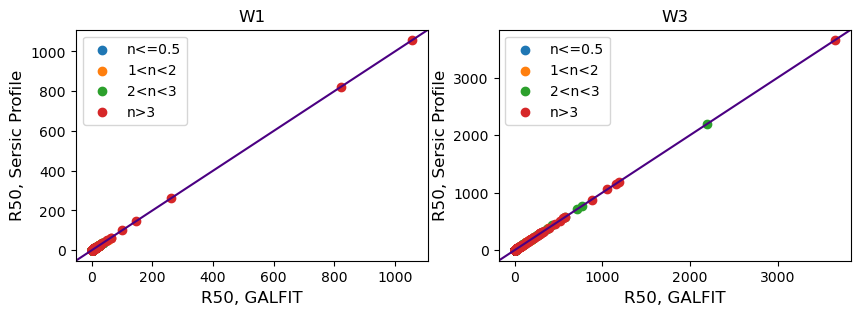

In [192]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(r50_w1[n_w1<=0.5], r50_w1_check[n_w1<=0.5],label='n<=0.5')
plt.scatter(r50_w1[(n_w1>1)&(n_w1<=2)], r50_w1_check[(n_w1>1)&(n_w1<=2)],label='1<n<2')
plt.scatter(r50_w1[(n_w1>2)&(n_w1<=3)], r50_w1_check[(n_w1>2)&(n_w1<=3)],label='2<n<3')
plt.scatter(r50_w1[(n_w1>3)], r50_w1_check[(n_w1>3)],label='n>3')
plt.axline((0,0),slope=1,color='indigo')
plt.title('W1')
plt.xlabel('R50, GALFIT',fontsize=12)
plt.ylabel('R50, Sersic Profile',fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(r50_w3[n_w3<=0.5], r50_w3_check[n_w3<=0.5],label='n<=0.5')
plt.scatter(r50_w3[(n_w3>1)&(n_w3<=2)], r50_w3_check[(n_w3>1)&(n_w3<=2)],label='1<n<2')
plt.scatter(r50_w3[(n_w3>2)&(n_w3<=3)], r50_w3_check[(n_w3>2)&(n_w3<=3)],label='2<n<3')
plt.scatter(r50_w3[(n_w3>3)], r50_w3_check[(n_w3>3)],label='n>3')
plt.axline((0,0),slope=1,color='indigo')
plt.title('W3')
plt.xlabel('R50, GALFIT',fontsize=12)
plt.ylabel('R50, Sersic Profile',fontsize=12)
plt.legend()
plt.show()

All points fall on the 1-to-1 line now!